In [ ]:
# default_exp models.aft

# Accelerated Failure Time Models
> AFT Model theory.

We can model the time to failure as:
$$
\log T_i = \mu + \xi_i
$$
where $\xi_i\sim p(\xi|\theta)$ and $\mu$ is the most likely log time of death (the mode of the distribution of $T_i$). We model log death as that way we do not need to restrict $\mu + \xi_i$ to be positive.

In the censored case, where $t_i$ is the time where an instance was censored, and $T_i$ is the unobserved time of death, we have:
$$
\begin{aligned}
\log T_i &= \mu(x_i) + \xi_i > \log t_i\\
\therefore \xi_i &> \log t_i - \mu(x_i)
\end{aligned}
$$
The log likelihood of the data ($\mathcal{D}$) can then shown to be:
$$
\begin{aligned}
\log p(\mathcal{D}) = \sum_{i=1}^N \mathcal{1}(y_i=1)\log p(\xi_i = \log t_i - \mu(x_i)) + \mathcal{1}(y_i=0)\log p(\xi_i &> \log t_i - \mu(x_i))
\end{aligned}
$$

In [ ]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
# export
class AFT(nn.Module):
    """
    Accelerated Failure Time model
    parameters:
    - logpdf (function): function that outputs log probabilty of error between time and expected time
    - log1cdf (function): function that outputs log of 1 - cumulative probabilty of error between time and expected time
    - dim (optional): input dimensionality of variables
    - h (optional): number of hidden nodes
    """
    def __init__(self, logpdf, logcdf, dim:int=0, h:tuple=()):
        super().__init__()
        self.logpdf, self.logcdf = logpdf, logcdf
        self.β = nn.Parameter(-torch.rand(1))
        if dim > 0:
            nodes = (dim,) + h + (1,)
            self.layers = nn.ModuleList([nn.Linear(a,b, bias=False) 
                                       for a,b in zip(nodes[:-1], nodes[1:])])
            
        self.eps = 1e-7

    def forward(self, t:torch.Tensor, x:torch.Tensor=None):
        # get the Kaplan Meier estimates
        μ = self.β
        if x:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
            μ += self.layers[-1](x)
#         μ = torch.exp(μ)
#         breakpoint()
        ξ = torch.log(t + self.eps) - μ
        logpdf = self.logpdf(ξ)
        logcdf = self.logcdf(ξ)
        return logpdf, logcdf
    
    def plot_survival_function(self, t:torch.Tensor, x:torch.Tensor=None):
        with torch.no_grad():
            # calculate cumulative hazard according to above
            _, Λ = self.forward(t, x)
            surv_fun = torch.exp(Λ)
        
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t, surv_fun)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()

In [ ]:
from torchlife.data import create_db
import pandas as pd

url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/survival/flchain.csv"
# url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/HSAUR/mastectomy.csv"
df = pd.read_csv(url).iloc[:,1:]
df.rename(columns={'futime':'t', 'death':'e'}, inplace=True)
df['t'] = df['t'] / df['t'].max()

db = create_db(df[['t', 'e']])

print(df.shape)
df.head()

(7874, 11)


,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,t,e,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,0.016299,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,0.245638,1,Neoplasms
2,94,F,1997,4.36,3.850,10,1.4,0,0.013231,1,Circulatory
3,92,F,1996,2.42,2.220,9,1.0,0,0.022052,1,Circulatory
4,93,F,1996,1.32,1.690,6,1.1,0,0.199233,1,Circulatory


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


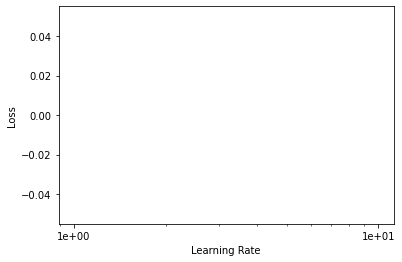

In [ ]:
# hide
from fastai.basics import Learner
from torchlife.models.error_dist import *
from torchlife.losses import aft_loss

# x_dim = df.shape[1] - 2
model = AFT(gumbel_logpdf, gumbel_logcdf)
learner = Learner(db, model, loss_func=aft_loss)
# wd = 1e-4
learner.lr_find(start_lr=1e-9, end_lr=1e-7)
learner.recorder.plot()

In [ ]:
learner.fit(epochs=10, lr=0.5)

epoch,train_loss,valid_loss,time
0,86.177505,5.916907,00:00
1,43.053604,5.353126,00:00
2,32.300701,5.468703,00:00
3,19.268324,5.926898,00:00
4,19.282757,6.094330,00:00
5,13.726945,6.116838,00:00
6,12.239197,6.146675,00:00
7,14.757230,6.933851,00:00
8,12.386668,7.083805,00:00
9,10.511874,6.687658,00:00


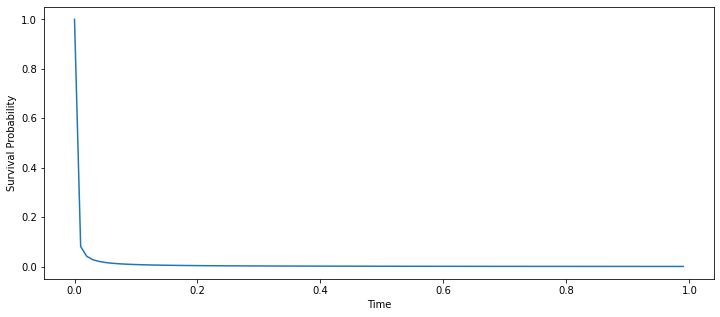

In [ ]:
model.plot_survival_function(torch.arange(0, 1, 0.01))

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted AFT_error_distributions.ipynb.
Converted AFT_models.ipynb.
Converted Cox_Proportional_Hazard.ipynb.
Converted KaplanMeier.ipynb.
Converted Losses.ipynb.
Converted PiecewiseHazard.ipynb.
Converted Survival Analysis Theory.ipynb.
Converted data.ipynb.
Converted index.ipynb.
Converted model.ipynb.
